Modified by Aslan Satary Dizaji (asataryd@umich.edu), Copyright (c) 2023.

Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

### Prerequisites
It is helpful to be familiar with **Foundation**, a multi-agent economic simulator built for the AI Economist ([paper here](https://arxiv.org/abs/2004.13332)). If you haven't worked with Foundation before, we highly recommend taking a look at our other tutorials:

- [Foundation: The Basics](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb)
- [Extending Foundation](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb)
- [Optimal Taxation Theory and Simulation](https://github.com/salesforce/ai-economist/blob/master/tutorials/optimal_taxation_theory_and_simulation.ipynb)

## Introduction

Welcome! This tutorial is the first of a series on doing distributed multi-agent reinforcement learning (MARL). Here, we specifically demonstrate how to integrate our multi-agent economic simulation, [Foundation](https://github.com/salesforce/ai-economist/tree/master/ai_economist/foundation), with [RLlib](https://github.com/ray-project/ray/tree/master/rllib), an open-source library for reinforcement learning. We chose to use RLlib, as it provides an easy-to-use and flexible library for MARL. A detailed documentation on RLlib is available [here](https://docs.ray.io/en/master/rllib.html).

We put together this tutorial notebook with the following key goals in mind:
- Provide an exposition to MARL. While there are many libraries and references out there for single-agent RL training, MARL training is not discussed as much, and there aren't many multi-agent RL libraries.
- Provide reference starting code to perform MARL training so the AI Economist community can focus more on building meaningful extensions to Foundation and better-performant algorithms.

We will cover the following concepts in this tutorial:
1. Adding an *environment wrapper* to make the economic simulation compatible with RLlib.
2. Creating a *trainer* object that holds the (multi-agent) policies for environment interaction.
3. Training all the agents in the economic simulation.
4. Generate a rollout using the trainer object and visualize it.

### Dependencies:
You can install the ai-economist package using 
- The pip package manager,
- By cloning the ai-economist package and installing the requirements (we shall use this when running on Colab):

In [1]:
import os, signal, sys, time
#IN_COLAB = 'google.colab' in sys.modules

#if IN_COLAB:
#    !git clone https://github.com/aslansd/modified-ai-economist.git
#
#    %cd modified-ai-economist
#    !pip install -e .
#    
#    # Restart the Python runtime to automatically use the installed packages.
#    print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
#    time.sleep(1)
#    os.kill(os.getpid(), signal.SIGKILL)
#else:
#    !pip install modified-ai-economist

Install OpenAI Gym to help define the environment's observation and action spaces for use with RLlib.

Install the `RLlib` reinforcement learning library:
- First, install TensorFlow,
- Then, install ray[rllib].

Note: RLlib natively supports TensorFlow (including TensorFlow Eager) as well as PyTorch, but most of its internals are framework agnostic. Here's a relevant [blogpost](https://medium.com/distributed-computing-with-ray/lessons-from-implementing-12-deep-rl-algorithms-in-tf-and-pytorch-1b412009297d) that compares running RLlib algorithms with TF and PyTorch. Overall, TF seems to run a bit faster than PyTorch, in our experience, and we will use that in this notebook.

In [2]:
# Change directory to the tutorials folder.
#IN_COLAB = 'google.colab' in sys.modules

#if IN_COLAB:
#    os.chdir("/content/ai-economist/tutorials")
#else:
#    os.chdir(os.path.dirname(os.path.abspath("__file__"))
#)

In [3]:
# Import foundation from source.
from modified_ai_economist import foundation

os.mkdir('Band')

In [4]:
import copy
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pdb
import scipy.io
from utils import plotting2

%matplotlib inline

## 1. Adding an Environment Wrapper 

We first define a configuration (introduced in [the basics tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basics.ipynb)) for the "gather-trade-build" environment with multiple mobile agents (that move, gather resources, build or trade) and a social planner that sets taxes according to (a scaled variant of) the 2018 US tax schedule.

In [5]:
env_config_dict = {
    # ===== SCENARIO CLASS =====  
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name' : 'sparse_aridisolatic_society',   # A sparse enviroment with band-like resources
    
    # ===== COMPONENTS =====   
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    # "component_name" refers to the Component class's name in the Component Registry (foundation.components).
    # {component_kwargs} is a dictionary of kwargs passed to the Component class.
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components' : [
        # (1) Building houses
        {'Build' : {
            'payment' :                      10,
            'payment_max_skill_multiplier' : np.array([5, 5, 5]),
            'skill_dist' :                   'pareto',
            'build_labor' :                  10,
        }},
        # (2) Trading collectible resources
        {'ContinuousDoubleAuction' : {
            'max_bid_ask' :    10,
            'order_labor' :    0.25,
            'order_duration' : 50,
            'max_num_orders' : 5,
        }},
        # (3) Movement and resource gathering
        {'Gather' : {
            'move_labor' :     1,
            'collect_labor' :  1,
            'skill_dist' :     'none',
        }},
        # (4) Arbitrary periodic bracket taxing
        {'ArbitraryPeriodicBracketTax' : {            
            # Similar to components/redistribution/PeriodicBracketTax
            'disable_taxes' :            False,
            'tax_model' :                'model_wrapper',
            'period' :                   100,
            'rate_min' :                 0.0,
            'rate_max' :                 1.0,
            'rate_disc' :                0.05,
            'n_brackets' :               7,
            'top_bracket_cutoff' :       100,
            'usd_scaling' :              1000.0,
            'bracket_spacing' :          'us-federal',
            'fixed_bracket_rates' :      None,
            'pareto_weight_type' :       'inverse_income',
            'saez_fixed_elas' :          None,
            'tax_annealing_schedule' :   None,
        }},
    ],
    
    # ===== STANDARD ARGUMENTS ======  
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment).
    'n_agents' :                          5,           # Number of non-planner agents (must be > 1)
    'world_size' :                        [40, 40],    # [Height, Width] of the env world
    'episode_length' :                    2000,        # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents' :          False,                                                 
    'multi_action_mode_planner' :         True,    
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations' :              True,
    
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks' :                     True,
    
    'allow_observation_scaling' :         True,
    
    # How often to save the dense logs.
    'dense_log_frequency' :               20,
    
    'world_dense_log_frequency' :         50,
    'collate_agent_step_and_reset_data' : False,
    'seed' :                              None,
    
    # ===== SCENARIO CLASS ARGUMENTS =====   
    # Other arguments that are added by the Scenario class (i.e. not defined in BaseEnvironment).
    # Similar to scenarios/simple_wood_and_stone_and_iron/dynamic_layout/Uniform    
    'planner_gets_spatial_info' :         True,
    'full_observability' :                False,
    'mobile_agent_observation_range' :    5,
    'starting_wood_coverage' :            0.10,
    'wood_regen_halfwidth' :              0.50,
    'wood_regen_weight' :                 0.10,
    'wood_max_health' :                   1,
    'wood_clumpiness' :                   0.35,
    'starting_stone_coverage' :           0.10,
    'stone_regen_halfwidth' :             0.50,
    'stone_regen_weight' :                0.10,
    'stone_max_health' :                  1,
    'stone_clumpiness' :                  0.35,
    'starting_iron_coverage' :            0.10,
    'iron_regen_halfwidth' :              0.50,
    'iron_regen_weight' :                 0.10,
    'iron_max_health' :                   1,
    'iron_clumpiness' :                   0.35,
    'gradient_steepness' :                1,
    'checker_source_blocks' :             False,
    'starting_agent_coin' :               50,
    'isoelastic_eta' :                    0.23,
    'energy_cost' :                       0.21,
    'energy_warmup_constant' :            0,
    'energy_warmup_method' :              'decay',
    'planner_reward_type' :               'coin_eq_times_productivity', # coin_eq_times_productivity, coin_maximin_times_productivity, inv_income_weighted_coin_endowments, inv_income_weighted_utility
    'mixing_weight_gini_vs_coin' :        0.0,
    'mixing_weight_maximin_vs_coin' :     0.0,
}

In [6]:
# Note: The code for sampling actions (this cell) and playing an episode (below) are general.  
# That is, it doesn't depend on the Scenario and Component classes used in the environment!

epsilon = 1e-19

def sample_random_action(agent, mask):
    """Sample random UNMASKED actions for an agent."""
    
    agent.multi_action_mode = True
    
    # Return a list of actions: 1 for each action subspace.
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p = (m_ + epsilon) / (m_ + epsilon).sum()) for m_ in split_masks]

    # Return a single action.
    else:
        return np.random.choice(np.arange(agent.action_spaces), p = mask / mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [7]:
from modified_ai_economist.foundation.agents import agent_registry as agents
from modified_ai_economist.foundation.components import component_registry as components
from modified_ai_economist.foundation.entities import endogenous_registry as endogenous
from modified_ai_economist.foundation.entities import landmark_registry as landmarks
from modified_ai_economist.foundation.entities import resource_registry as resources
from modified_ai_economist.foundation.scenarios import scenario_registry as scenarios

def make_env_instance(scenario_name, **kwargs):
    scenario_class = scenarios.get(scenario_name)
    return scenario_class(**kwargs)

In [8]:
env = make_env_instance(**env_config_dict)
env

In [9]:
obs = env.reset()
obs

{'0': {'world-map': array([[[0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]],
  
         [[0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0.,

In [10]:
actions = sample_random_actions(env, obs)
actions

{'0': [1, 8, 4, 5, 0, 6, 8, 0],
 '1': [1, 6, 0, 6, 6, 3, 8, 4],
 '2': [0, 5, 10, 10, 8, 4, 6, 3],
 '3': [0, 5, 5, 4, 8, 0, 5, 2],
 '4': [0, 9, 6, 7, 3, 1, 9, 3],
 'p': [0, 17, 16, 21, 12, 9, 9]}

In [11]:
obs, rew, done, info = env.step(actions)

In [12]:
obs

{'0': {'world-map': array([[[0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]],
  
         [[0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0.,

In [13]:
rew

{'0': 7.445021570398179,
 '1': 3.62127945404254,
 '2': -1.552134273970406,
 '3': 2.724568834017809,
 '4': -1.1426081824606413,
 'p': 2.073754298562818}

In [14]:
done

{'__all__': False}

In [15]:
obs.keys()

for key, val in obs['1'].items(): 
    print("{:50} {}".format(key, type(val)))
    
for agent_idx, reward in rew.items(): 
    print("{:2} {:.3f}".format(agent_idx, reward))

world-map                                          <class 'numpy.ndarray'>
world-idx_map                                      <class 'numpy.ndarray'>
time                                               <class 'list'>
flat                                               <class 'numpy.ndarray'>
action_mask                                        <class 'numpy.ndarray'>
0  7.445
1  3.621
2  -1.552
3  2.725
4  -1.143
p  2.074


In [16]:
info

{'0': {}, '1': {}, '2': {}, '3': {}, '4': {}, 'p': {}}

In [17]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    
    plotting2.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (with plotting).
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)

        if ((t + 1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t + 1) % plot_every) != 0:
        do_plot(env, ax, fig)
        
    fig.savefig('Band/Large Visualization of the World_Band.png')

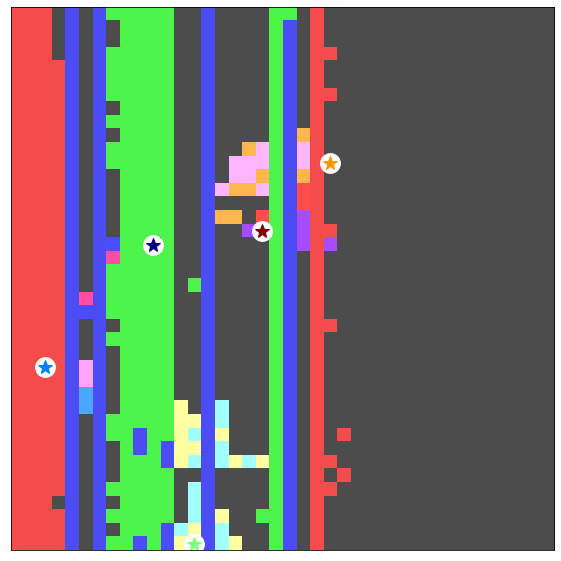

In [18]:
# Play another episode. This time tell the environment to do dense logging.
play_random_episode(env, plot_every=100, do_dense_logging=True)

# Grab the dense log from the env.
dense_log = env.previous_episode_dense_log

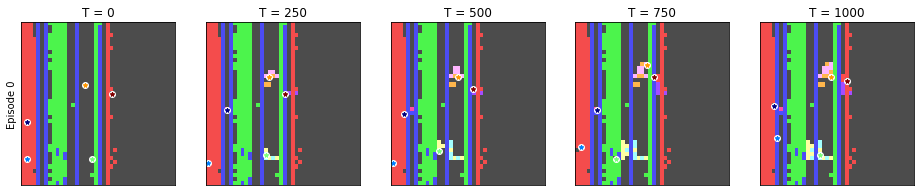

In [19]:
# Show the evolution of the world state from t=0 to t=1000.
fig = plotting2.vis_world_range(dense_log, t0=0, tN=1000, N=5)

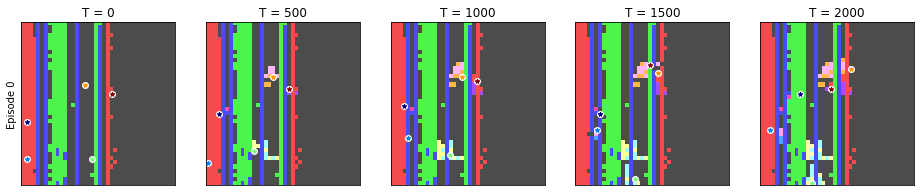

In [20]:
# Show the evolution of the world state over the full episode.
fig = plotting2.vis_world_range(dense_log, N=5)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 _____|_ Agent  4 ____
Cost (Wood)    :   6.71 (n= 28) |   6.72 (n= 18) |   7.92 (n= 24) |   6.72 (n= 32) |   7.42 (n= 26)
Cost (Stone)   :   6.06 (n= 17) |   6.44 (n= 18) |   6.42 (n= 19) |   7.25 (n= 16) |   5.25 (n= 20)
Cost (Iron)    :   3.50 (n=  4) |   4.83 (n=  6) |   2.86 (n=  7) |   4.62 (n=  8) |   4.67 (n=  6)

Income (Wood)  :   7.33 (n= 27) |   7.31 (n= 29) |   6.60 (n= 20) |   6.77 (n= 31) |   7.38 (n= 21)
Income (Stone) :   6.73 (n= 15) |   7.04 (n= 24) |   4.69 (n= 16) |   6.20 (n= 10) |   6.20 (n= 25)
Income (Iron)  :   4.50 (n=  4) |   4.33 (n=  6) |   3.33 (n=  6) |   4.80 (n=  5) |   4.00 (n= 10)
Income (Build) :  30.12 (n=  4) |  28.72 (n=  4) |  13.98 (n= 28) |  36.07 (n= 19) |  15.75 (n=  9)


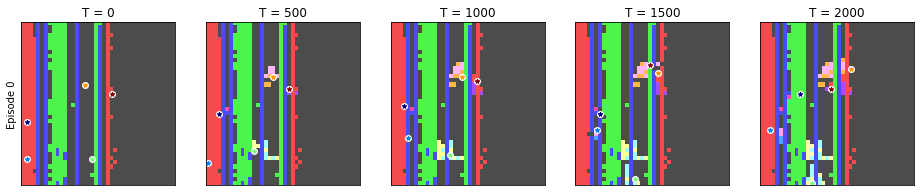

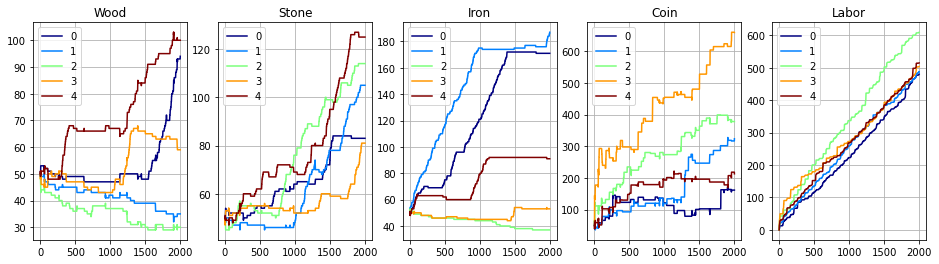

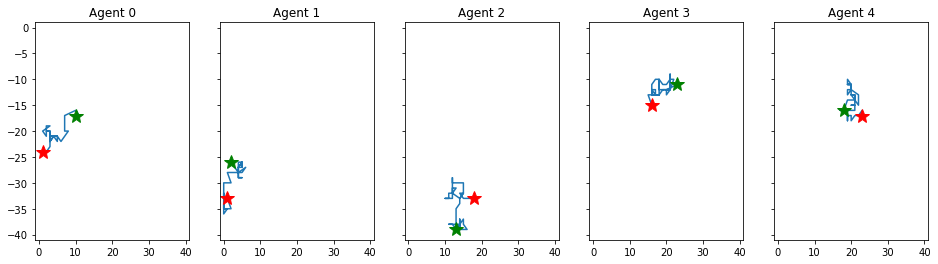

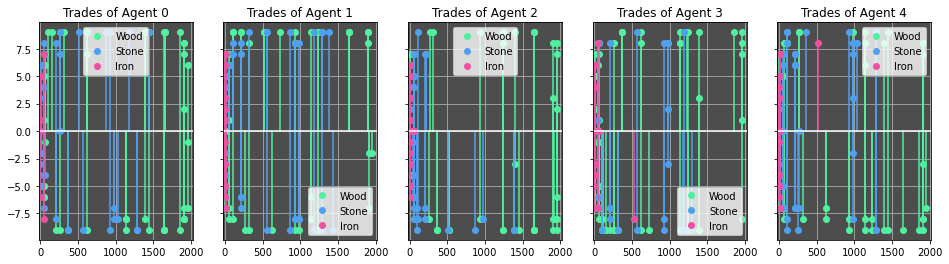

In [21]:
# Use the "breakdown" tool to visualize the world state, agent-wise quantities, movement, and trading events.
(fig0, fig1, fig2, fig3), incomes, endows, c_trades, all_builds, variables_matrix = plotting2.breakdown(dense_log, environment_type = "Band", episode_length=2000)

In [22]:
incomes

{'Sell Wood': [198, 212, 132, 210, 155],
 'Buy Wood': [-188, -121, -190, -215, -193],
 'Sell Stone': [101, 169, 75, 62, 155],
 'Buy Stone': [-103, -116, -122, -116, -105],
 'Sell Iron': [18, 26, 20, 24, 40],
 'Buy Iron': [-14, -29, -20, -37, -28],
 'Build': [120.48700354839298,
  114.89081319251963,
  391.315953930122,
  685.2730290468264,
  141.7613480360667],
 'Total': array([132.48700355, 255.89081319, 286.31595393, 613.27302905,
        165.76134804])}

In [23]:
endows

[161, 323, 378, 659, 213]

In [24]:
c_trades

{'Wood': [{'t': 0,
   't_ask': 0,
   't_bid': 0,
   'commodity': 'Wood',
   'buyer': 3,
   'bid': 7,
   'bid_lifetime': 0,
   'seller': 0,
   'ask': 4,
   'ask_lifetime': 0,
   'price': 4,
   'cost': 4,
   'income': 4},
  {'t': 0,
   't_ask': 0,
   't_bid': 0,
   'commodity': 'Wood',
   'buyer': 4,
   'bid': 7,
   'bid_lifetime': 0,
   'seller': 3,
   'ask': 4,
   'ask_lifetime': 0,
   'price': 4,
   'cost': 4,
   'income': 4},
  {'t': 1,
   't_ask': 1,
   't_bid': 1,
   'commodity': 'Wood',
   'buyer': 1,
   'bid': 7,
   'bid_lifetime': 0,
   'seller': 4,
   'ask': 0,
   'ask_lifetime': 0,
   'price': 0,
   'cost': 0,
   'income': 0},
  {'t': 1,
   't_ask': 1,
   't_bid': 1,
   'commodity': 'Wood',
   'buyer': 2,
   'bid': 7,
   'bid_lifetime': 0,
   'seller': 1,
   'ask': 4,
   'ask_lifetime': 0,
   'price': 4,
   'cost': 4,
   'income': 4},
  {'t': 1,
   't_ask': 1,
   't_bid': 0,
   'commodity': 'Wood',
   'buyer': 1,
   'bid': 6,
   'bid_lifetime': 1,
   'seller': 2,
   'ask': 1,


In [25]:
all_builds

[{'t': 0,
  'builder': 3,
  'type': 'red',
  'loc': [15, 16],
  'income': 47.32356658933192},
 {'t': 0,
  'builder': 2,
  'type': 'red',
  'loc': [33, 18],
  'income': 16.868326100730773},
 {'t': 1,
  'builder': 3,
  'type': 'red',
  'loc': [15, 15],
  'income': 47.32356658933192},
 {'t': 1,
  'builder': 4,
  'type': 'blue',
  'loc': [17, 23],
  'income': 17.873760960570895},
 {'t': 5,
  'builder': 2,
  'type': 'blue',
  'loc': [33, 17],
  'income': 11.082813465706511},
 {'t': 7,
  'builder': 2,
  'type': 'red',
  'loc': [33, 16],
  'income': 16.868326100730773},
 {'t': 10,
  'builder': 3,
  'type': 'blue',
  'loc': [13, 15],
  'income': 27.880408757470107},
 {'t': 54,
  'builder': 3,
  'type': 'red',
  'loc': [13, 16],
  'income': 47.32356658933192},
 {'t': 62,
  'builder': 2,
  'type': 'blue',
  'loc': [33, 15],
  'income': 11.082813465706511},
 {'t': 63,
  'builder': 3,
  'type': 'red',
  'loc': [13, 17],
  'income': 47.32356658933192},
 {'t': 66,
  'builder': 3,
  'type': 'blue',
 

In [26]:
variables_matrix

array([[[ 4.        ,  3.        ,  5.        ,         nan,
                 nan,         nan],
        [        nan,  2.        ,  7.        ,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, 16.8683261 ,
                 nan,         nan],
        [ 4.        ,         nan,  7.        , 47.32356659,
                 nan,         nan],
        [ 4.        ,  3.        ,  6.        ,         nan,
                 nan,         nan]],

       [[        nan,  3.        ,  5.        ,         nan,
                 nan,         nan],
        [ 6.        ,  3.        ,  1.        ,         nan,
                 nan,         nan],
        [ 6.        ,  3.        ,  1.        ,         nan,
                 nan,         nan],
        [        nan,  1.        ,         nan, 47.32356659,
                 nan,         nan],
        [        nan,  1.        ,         nan,         nan,
         17.87376096,         nan]],

       [[        nan,     

Like we have seen in earlier [tutorials](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb), using `env = foundation.make_env_instance(**env_config)` creates an environment instance `env` with the specified configuration.

In order to use this environment with RLlib, we will also need to add the environment's `observation_space` and `action_space` attributes. Additionally, the environment itself must subclass the [`MultiAgentEnv`](https://github.com/ray-project/ray/blob/master/rllib/env/multi_agent_env.py) interface, which can return observations and rewards from multiple ready agents per step. To this end, we use an environment [wrapper](https://github.com/salesforce/ai-economist/blob/master/tutorials/rllib/env_wrapper.py).

In [27]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lion\anaconda3\envs

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (74,)
flat           : (198,)
time           : (1,)
world-idx_map  : (4, 10, 10)
world-map      : (10, 10, 10)


[EnvWrapper] Obs (p)   
action_mask    : (154,)
flat           : (122,)
p0             : (9,)
p1             : (9,)
p2             : (9,)
p3             : (9,)
p4             : (9,)
time           : (1,)
world-idx_map  : (4, 40, 40)
world-map      : (9, 40, 40)


[EnvWrapper] Action (a) Discrete(74)
[EnvWrapper] Action (p) MultiDiscrete([22 22 22 22 22 22 22])


Upon applying the wrapper to our environment, we have now defined observation and action spaces for the agents and the planner, indicated with `(a)` and `(p)` respectively. Also, (a useful tip) you can still access the environment instance and its attributes simply by using `env_obj.env`

In summary, the observation spaces are represented as `Box` objects and the action spaces as `Discrete` objects (for more details on these types, see the OpenAI documentation [page](https://gym.openai.com/docs/#spaces)).

Briefly looking at the shapes of the observation features (the numbers in parentheses), you will see that we have some one-dimensional features (e.g. `action-mask`, `flat`, `time`) as well as spatial features (e.g., `world-idx-map`, `world-map`)

A couple of quick notes:
- An `action_mask` is used to mask out the actions that are not allowed by the environment. For instance, a mobile agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down", and the corresponding actions in the mask would be nulled out. Now, the RL agent can still recommend to move "Left" or "Down", but the action isn't really taken.
- The key `flat` arises since we set `flatten_observations': True`. Accordingly, the scalar and vector raw observations are all concatenated into this single key. If you're curious to see the entire set of raw observations, do set `flatten_observations': False` in the env_config, and re-run the above cell.

Looking at the action spaces, the mobile agents can take 80 possible actions (including 1 NO-OP action or do nothing (always indexed 0), 66 trading-related actions, 4 move actions along the four directions, 3 build actions, and 6 vote actions).

The planner sets the tax rates for 7 brackets, each from 0-100% in steps of 5%, so that's 21 values. Adding the NO-OP action brings the planner action space to `MultiDiscrete([22 22 22 22 22 22 22])`.

## 2. Creating a *Trainer* Object

In order to train our economic simulation environment with RLlib, you will need familiarity with one of the key classes: the [`Trainer`](https://docs.ray.io/en/master/rllib-training.html). The trainer object maintains the relationships that connect each agent in the environment to its corresponding trainable policy, and essentially helps in training, checkpointing policies and inferring actions. It helps to co-ordinate the workflow of collecting rollouts and optimizing the various policies via a reinforcement learning algorithm. Inherently, RLlib maintains a wide suite of [algorithms](https://docs.ray.io/en/master/rllib-algorithms.html) for multi-agent learning (which was another strong reason for us to consider using RLlib) - available options include SAC, PPO, PG, A2C, A3C, IMPALA, ES, DDPG, DQN, MARWIL, APEX, and APEX_DDPG. For the remainder of this tutorial, we will stick to using [Proximal Policy Optimization](https://openai.com/blog/openai-baselines-ppo/) (PPO), an algorithm known to perform well generally.

Every algorithm has a corresponding trainer object; in the context of PPO, we invoke the `PPOTrainer` object.

In [28]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

PPOTrainer can be instantiated with 
- `env`: an environment creator (i.e, RLlibEnvWrapper() in our case)
- `config`: algorithm-specific configuration data for setting the various components of the RL training loop including the environment, rollout worker processes, training resources, degree of parallelism, framework used, and the policy exploration strategies.

Note: There are several configuration settings related to policy architectures, rollout collection, minibatching, and other important hyperparameters, that need to be set carefully in order to train effectively. For the sake of the high-level exposition, we allow RLlib to use most of the the default settings. Check out the list of default [common configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-training.html#common-parameters) and default [PPO-specific configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-algorithms.html?highlight=PPO#proximal-policy-optimization-ppo). Custom environment configurations may be passed to environment creator via `config["env_config"]`.

RLlib also chooses default built-in [models](https://docs.ray.io/en/releases-0.8.4/rllib-models.html#built-in-models-and-preprocessors) for processing the observations. The models are picked based on a simple heuristic: a [vision](https://github.com/ray-project/ray/blob/master/rllib/models/tf/visionnet.py) network for observations that have shape of length larger than 2 (for example, (84 x 84 x 3)), and a [fully connected](https://github.com/ray-project/ray/blob/master/rllib/models/tf/fcnet.py) network for everything else. Custom models can be configured via the `config["policy"]["model"]` key.

In the context of multi-agent training, we will also need to set the multi-agent configuration:
```python
"multiagent": {
        # Map of type MultiAgentPolicyConfigDict from policy ids to tuples
        # of (policy_cls, obs_space, act_space, config). This defines the
        # observation and action spaces of the policies and any extra config.
        "policies": {},
        # Function mapping agent ids to policy ids.
        "policy_mapping_fn": None,
        # Optional list of policies to train, or None for all policies.
        "policies_to_train": None,
    },
```

To this end, let's notate the agent policy id by `"a"` and the planner policy id by `"p"`. We can set `policies`, `policy_mapping_fun` and `policies_to_train` as follows.

In [29]:
from ray.rllib.models.catalog import ModelCatalog
from rllib.tf_models import KerasConvLSTM, RandomAction

ModelCatalog.register_custom_model(KerasConvLSTM.custom_name, KerasConvLSTM)
ModelCatalog.register_custom_model(RandomAction.custom_name, RandomAction)


policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        #{},
        {'clip_param': 0.3,
         'entropy_coeff': 0.025,
         'entropy_coeff_schedule': None,
         'gamma': 0.998,
         'grad_clip': 10.0,
         'kl_coeff': 0.0,
         'kl_target': 0.01,
         'lambda': 0.98,
         'lr': 0.0003,
         'lr_schedule': None,
         'model': {'custom_model': 'keras_conv_lstm',                  
                   'custom_model_config': {'fc_dim': 128,
                                           'idx_emb_dim': 4,
                                           'input_emb_vocab': 100,
                                           'lstm_cell_size': 128,
                                           'num_conv': 2, 
                                           'num_fc': 2},
                   'max_seq_len': 25},
         'use_gae': True,
         'vf_clip_param': 50.0,
         'vf_loss_coeff': 0.05,
         'vf_share_layers': False}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        #{},
        {'clip_param': 0.3,
         'entropy_coeff': 0.125,
         'entropy_coeff_schedule': [[0, 2.0], [50000000, 0.125]],
         'gamma': 0.998,
         'grad_clip': 10.0,
         'kl_coeff': 0.0,
         'kl_target': 0.01,
         'lambda': 0.98,
         'lr': 0.0001,
         'lr_schedule': None,
         'model': {'custom_model': 'keras_conv_lstm',
                   'custom_model_config': {'fc_dim': 256,
                                           'idx_emb_dim': 4,
                                           'input_emb_vocab': 100,
                                           'lstm_cell_size': 256,
                                           'num_conv': 2, 
                                           'num_fc': 2},
                   'max_seq_len': 25},
         'use_gae': True,
         'vf_clip_param': 50.0,
         'vf_loss_coeff': 0.05,
         'vf_share_layers': False}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

Create a multiagent trainer config holding the trainable policies and their mappings.

In [30]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

With distributed RL, architectures typically comprise several **roll-out** and **trainer** workers operating in tandem
![](assets/distributed_rl_architecture.png)

The roll-out workers repeatedly step through the environment to generate and collect roll-outs in parallel, using the actions sampled from the policy models on the roll-out workers or provided by the trainer worker.
Roll-out workers typically use CPU machines, and sometimes, GPU machines for richer environments.
Trainer workers gather the roll-out data (asynchronously) from the roll-out workers and optimize policies on CPU or GPU machines.

In this context, we can also add a `num_workers` configuration parameter to specify the number of rollout workers, i.e, those responsible for gathering rollouts. Note: setting `num_workers=0` will mean the rollouts will be collected by the trainer worker itself. Also, each worker can collect rollouts from multiple environments in parallel, which is specified in `num_envs_per_worker`; there will be a total of `num_workers` $\times$ `num_envs_per_worker` environment replicas used to gather rollouts.
Note: below, we also update some of the default trainer settings to keep the iteration time small.

In [31]:
trainer_config.update(
    {
        "num_workers": 6,
        "num_envs_per_worker": 1,
        # Other training parameters
        "train_batch_size": 4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1
    }
)

Finally, we need to add the environment configuration to the trainer configuration.

In [32]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

One the training configuration is set, we will need to initialize ray and create the PPOTrainer object.

In [33]:
# Initialize Ray
# ray.init(webui_host="127.0.0.1")
ray.init()

2023-05-13 13:07:58,459	INFO resource_spec.py:212 -- Starting Ray with 32.13 GiB memory available for workers and up to 16.07 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2023-05-13 13:07:58,837	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '172.18.32.1',
 'raylet_ip_address': '172.18.32.1',
 'redis_address': '172.18.32.1:6379',
 'object_store_address': 'tcp://127.0.0.1:53180',
 'raylet_socket_name': 'tcp://127.0.0.1:64564',
 'webui_url': 'localhost:8265',
 'session_dir': 'C:\\Users\\Lion\\AppData\\Local\\Temp\\ray\\session_2023-05-13_13-07-58_456755_2192'}

In [34]:
# Create the PPO trainer.
trainer = PPOTrainer(env=RLlibEnvWrapper, config=trainer_config)

2023-05-13 13:08:05,241	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2023-05-13 13:08:05,243	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2023-05-13 13:08:05,243	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-05-13 13:08:05,290	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-05-13 13:08:08,678	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


(pid=4524) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=4524)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=4524) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=4524)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=4524) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=4524)   _np_qint16 

(pid=9440) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=9440)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=9440) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=9440)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=9440) C:\Users\Lion\anaconda3\envs\modified-ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pi

(pid=9440) 2023-05-13 13:08:16,277	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(pid=4524) 2023-05-13 13:08:16,281	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(pid=16716) 2023-05-13 13:08:16,294	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(pid=6064) 2023-05-13 13:08:16,322	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(pid=11524) 2023-05-13 13:08:16,301	WARNING catalog.py:333 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(pid=2016) 2023-05-13 13:08:16,309	WARNING catalog.py:333 -- Custom ModelV2 should accep

2023-05-13 13:08:31,281	INFO trainable.py:181 -- _setup took 26.039 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


## 3. Perform Training

By default, the results will be logged to a subdirectory of `~/ray_results`. This subdirectory will contain a file `params.json` which contains the hyperparameters, a file `result.json` which contains a training summary for each episode and a TensorBoard file that can be used to visualize training process with TensorBoard by running|
```shell
tensorboard --logdir ~/ray_results
```

In [35]:
NUM_ITERS = 5000

episode_reward_mean = np.zeros(NUM_ITERS)

for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    
    result = trainer.train()
    episode_reward_mean[iteration] = result.get('episode_reward_mean')
    print(f'''episode_reward_mean: {episode_reward_mean[iteration]}''')

********** Iter : 0 **********
episode_reward_mean: nan
********** Iter : 1 **********
episode_reward_mean: nan
********** Iter : 2 **********
episode_reward_mean: 1350.8781207212578
********** Iter : 3 **********
episode_reward_mean: 1350.8781207212578
********** Iter : 4 **********
episode_reward_mean: 1212.6183695607274
********** Iter : 5 **********
episode_reward_mean: 1212.6183695607276
********** Iter : 6 **********
episode_reward_mean: 1212.6183695607276
********** Iter : 7 **********
episode_reward_mean: 1014.2095432044921
********** Iter : 8 **********
episode_reward_mean: 1014.2095432044924
********** Iter : 9 **********
episode_reward_mean: 980.2927920442444
********** Iter : 10 **********
episode_reward_mean: 980.2927920442444
********** Iter : 11 **********
episode_reward_mean: 980.2927920442444
********** Iter : 12 **********
episode_reward_mean: 1065.2880115200362
********** Iter : 13 **********
episode_reward_mean: 1065.2880115200362
********** Iter : 14 **********
epi

episode_reward_mean: 547.6414715367495
********** Iter : 117 **********
episode_reward_mean: 534.1972895752541
********** Iter : 118 **********
episode_reward_mean: 534.1972895752541
********** Iter : 119 **********
episode_reward_mean: 530.212060690824
********** Iter : 120 **********
episode_reward_mean: 530.2120606908242
********** Iter : 121 **********
episode_reward_mean: 530.2120606908242
********** Iter : 122 **********
episode_reward_mean: 542.240484422472
********** Iter : 123 **********
episode_reward_mean: 542.2404844224719
********** Iter : 124 **********
episode_reward_mean: 546.711305987702
********** Iter : 125 **********
episode_reward_mean: 546.711305987702
********** Iter : 126 **********
episode_reward_mean: 546.711305987702
********** Iter : 127 **********
episode_reward_mean: 541.451160444426
********** Iter : 128 **********
episode_reward_mean: 541.4511604444261
********** Iter : 129 **********
episode_reward_mean: 548.6604071076127
********** Iter : 130 *********

episode_reward_mean: 627.7884061522279
********** Iter : 231 **********
episode_reward_mean: 627.7884061522279
********** Iter : 232 **********
episode_reward_mean: 616.0821467282822
********** Iter : 233 **********
episode_reward_mean: 616.0821467282822
********** Iter : 234 **********
episode_reward_mean: 608.3985945375972
********** Iter : 235 **********
episode_reward_mean: 608.3985945375972
********** Iter : 236 **********
episode_reward_mean: 608.3985945375972
********** Iter : 237 **********
episode_reward_mean: 592.8068811124356
********** Iter : 238 **********
episode_reward_mean: 592.8068811124355
********** Iter : 239 **********
episode_reward_mean: 597.3735143948268
********** Iter : 240 **********
episode_reward_mean: 597.3735143948268
********** Iter : 241 **********
episode_reward_mean: 597.3735143948268
********** Iter : 242 **********
episode_reward_mean: 597.7074443857124
********** Iter : 243 **********
episode_reward_mean: 597.7074443857126
********** Iter : 244 ***

episode_reward_mean: 1702.8549722774735
********** Iter : 345 **********
episode_reward_mean: 1702.854972277473
********** Iter : 346 **********
episode_reward_mean: 1702.854972277473
********** Iter : 347 **********
episode_reward_mean: 1720.2907669676179
********** Iter : 348 **********
episode_reward_mean: 1720.2907669676183
********** Iter : 349 **********
episode_reward_mean: 1695.9981770149077
********** Iter : 350 **********
episode_reward_mean: 1695.998177014908
********** Iter : 351 **********
episode_reward_mean: 1695.998177014908
********** Iter : 352 **********
episode_reward_mean: 1677.2369327973595
********** Iter : 353 **********
episode_reward_mean: 1677.2369327973593
********** Iter : 354 **********
episode_reward_mean: 1658.526486665524
********** Iter : 355 **********
episode_reward_mean: 1658.5264866655243
********** Iter : 356 **********
episode_reward_mean: 1658.5264866655243
********** Iter : 357 **********
episode_reward_mean: 1709.0623927682784
********** Iter 

episode_reward_mean: 1684.3859426995787
********** Iter : 458 **********
episode_reward_mean: 1684.3859426995782
********** Iter : 459 **********
episode_reward_mean: 1699.8527234949368
********** Iter : 460 **********
episode_reward_mean: 1699.8527234949368
********** Iter : 461 **********
episode_reward_mean: 1699.8527234949368
********** Iter : 462 **********
episode_reward_mean: 1680.3488243350616
********** Iter : 463 **********
episode_reward_mean: 1680.3488243350616
********** Iter : 464 **********
episode_reward_mean: 1677.6596496905652
********** Iter : 465 **********
episode_reward_mean: 1677.6596496905654
********** Iter : 466 **********
episode_reward_mean: 1677.6596496905654
********** Iter : 467 **********
episode_reward_mean: 1674.747484986909
********** Iter : 468 **********
episode_reward_mean: 1674.7474849869084
********** Iter : 469 **********
episode_reward_mean: 1673.7350648590123
********** Iter : 470 **********
episode_reward_mean: 1673.7350648590127
********** I

episode_reward_mean: 1915.9769953998991
********** Iter : 571 **********
episode_reward_mean: 1915.9769953998991
********** Iter : 572 **********
episode_reward_mean: 1949.9010685625208
********** Iter : 573 **********
episode_reward_mean: 1949.901068562521
********** Iter : 574 **********
episode_reward_mean: 1941.6204584646973
********** Iter : 575 **********
episode_reward_mean: 1941.6204584646975
********** Iter : 576 **********
episode_reward_mean: 1941.6204584646975
********** Iter : 577 **********
episode_reward_mean: 1972.5476002931696
********** Iter : 578 **********
episode_reward_mean: 1972.5476002931694
********** Iter : 579 **********
episode_reward_mean: 1951.1617382601771
********** Iter : 580 **********
episode_reward_mean: 1951.1617382601773
********** Iter : 581 **********
episode_reward_mean: 1951.1617382601773
********** Iter : 582 **********
episode_reward_mean: 1934.8741117085347
********** Iter : 583 **********
episode_reward_mean: 1934.8741117085347
********** I

episode_reward_mean: 1728.499676229217
********** Iter : 684 **********
episode_reward_mean: 1797.51109900888
********** Iter : 685 **********
episode_reward_mean: 1797.51109900888
********** Iter : 686 **********
episode_reward_mean: 1797.51109900888
********** Iter : 687 **********
episode_reward_mean: 1836.678342891285
********** Iter : 688 **********
episode_reward_mean: 1836.678342891285
********** Iter : 689 **********
episode_reward_mean: 1838.457791957309
********** Iter : 690 **********
episode_reward_mean: 1838.4577919573087
********** Iter : 691 **********
episode_reward_mean: 1838.4577919573087
********** Iter : 692 **********
episode_reward_mean: 1844.3416266370436
********** Iter : 693 **********
episode_reward_mean: 1844.3416266370439
********** Iter : 694 **********
episode_reward_mean: 1840.487854959967
********** Iter : 695 **********
episode_reward_mean: 1840.4878549599678
********** Iter : 696 **********
episode_reward_mean: 1840.4878549599678
********** Iter : 697 

episode_reward_mean: 1790.221834255022
********** Iter : 797 **********
episode_reward_mean: 1774.104368913667
********** Iter : 798 **********
episode_reward_mean: 1774.1043689136673
********** Iter : 799 **********
episode_reward_mean: 1782.132073849348
********** Iter : 800 **********
episode_reward_mean: 1782.1320738493478
********** Iter : 801 **********
episode_reward_mean: 1782.1320738493478
********** Iter : 802 **********
episode_reward_mean: 1779.3197154943787
********** Iter : 803 **********
episode_reward_mean: 1779.3197154943791
********** Iter : 804 **********
episode_reward_mean: 1736.5203158159968
********** Iter : 805 **********
episode_reward_mean: 1736.5203158159961
********** Iter : 806 **********
episode_reward_mean: 1736.5203158159961
********** Iter : 807 **********
episode_reward_mean: 1694.8649802841132
********** Iter : 808 **********
episode_reward_mean: 1694.8649802841135
********** Iter : 809 **********
episode_reward_mean: 1695.1750745971385
********** Ite

episode_reward_mean: 2346.0430836532723
********** Iter : 910 **********
episode_reward_mean: 2346.0430836532723
********** Iter : 911 **********
episode_reward_mean: 2346.0430836532723
********** Iter : 912 **********
episode_reward_mean: 2339.695140788439
********** Iter : 913 **********
episode_reward_mean: 2339.695140788439
********** Iter : 914 **********
episode_reward_mean: 2321.6865843864875
********** Iter : 915 **********
episode_reward_mean: 2321.6865843864875
********** Iter : 916 **********
episode_reward_mean: 2321.6865843864875
********** Iter : 917 **********
episode_reward_mean: 2243.778118399864
********** Iter : 918 **********
episode_reward_mean: 2243.778118399864
********** Iter : 919 **********
episode_reward_mean: 2240.4592514322335
********** Iter : 920 **********
episode_reward_mean: 2240.4592514322335
********** Iter : 921 **********
episode_reward_mean: 2240.4592514322335
********** Iter : 922 **********
episode_reward_mean: 2263.9765214133004
********** Iter

episode_reward_mean: 2073.7376963876177
********** Iter : 1023 **********
episode_reward_mean: 2073.737696387618
********** Iter : 1024 **********
episode_reward_mean: 2123.6267038194496
********** Iter : 1025 **********
episode_reward_mean: 2123.6267038194505
********** Iter : 1026 **********
episode_reward_mean: 2123.6267038194505
********** Iter : 1027 **********
episode_reward_mean: 2109.943054505161
********** Iter : 1028 **********
episode_reward_mean: 2109.9430545051605
********** Iter : 1029 **********
episode_reward_mean: 2092.8386774232804
********** Iter : 1030 **********
episode_reward_mean: 2092.8386774232804
********** Iter : 1031 **********
episode_reward_mean: 2092.8386774232804
********** Iter : 1032 **********
episode_reward_mean: 2079.477036138592
********** Iter : 1033 **********
episode_reward_mean: 2079.4770361385927
********** Iter : 1034 **********
episode_reward_mean: 2086.496665766804
********** Iter : 1035 **********
episode_reward_mean: 2086.496665766804
***

episode_reward_mean: 1913.7774259942466
********** Iter : 1135 **********
episode_reward_mean: 1913.7774259942466
********** Iter : 1136 **********
episode_reward_mean: 1913.7774259942466
********** Iter : 1137 **********
episode_reward_mean: 1953.7450470944996
********** Iter : 1138 **********
episode_reward_mean: 1953.7450470944991
********** Iter : 1139 **********
episode_reward_mean: 1957.1122974379032
********** Iter : 1140 **********
episode_reward_mean: 1957.1122974379034
********** Iter : 1141 **********
episode_reward_mean: 1957.1122974379034
********** Iter : 1142 **********
episode_reward_mean: 1980.0667852042236
********** Iter : 1143 **********
episode_reward_mean: 1980.066785204224
********** Iter : 1144 **********
episode_reward_mean: 1995.9051344251386
********** Iter : 1145 **********
episode_reward_mean: 1995.905134425138
********** Iter : 1146 **********
episode_reward_mean: 1995.905134425138
********** Iter : 1147 **********
episode_reward_mean: 2021.2782666730106
*

episode_reward_mean: 2101.795420067884
********** Iter : 1247 **********
episode_reward_mean: 2149.2441494011628
********** Iter : 1248 **********
episode_reward_mean: 2149.2441494011623
********** Iter : 1249 **********
episode_reward_mean: 2129.189629850579
********** Iter : 1250 **********
episode_reward_mean: 2129.189629850579
********** Iter : 1251 **********
episode_reward_mean: 2129.189629850579
********** Iter : 1252 **********
episode_reward_mean: 2182.6421076370225
********** Iter : 1253 **********
episode_reward_mean: 2182.642107637023
********** Iter : 1254 **********
episode_reward_mean: 2232.2268868056412
********** Iter : 1255 **********
episode_reward_mean: 2232.2268868056417
********** Iter : 1256 **********
episode_reward_mean: 2232.2268868056417
********** Iter : 1257 **********
episode_reward_mean: 2296.67089446897
********** Iter : 1258 **********
episode_reward_mean: 2296.67089446897
********** Iter : 1259 **********
episode_reward_mean: 2230.10522060633
*********

episode_reward_mean: 2007.76699471524
********** Iter : 1359 **********
episode_reward_mean: 1986.61745238001
********** Iter : 1360 **********
episode_reward_mean: 1986.6174523800096
********** Iter : 1361 **********
episode_reward_mean: 1986.6174523800096
********** Iter : 1362 **********
episode_reward_mean: 1922.2332488326458
********** Iter : 1363 **********
episode_reward_mean: 1922.2332488326463
********** Iter : 1364 **********
episode_reward_mean: 1938.2306114504825
********** Iter : 1365 **********
episode_reward_mean: 1938.230611450482
********** Iter : 1366 **********
episode_reward_mean: 1938.230611450482
********** Iter : 1367 **********
episode_reward_mean: 1939.903454235201
********** Iter : 1368 **********
episode_reward_mean: 1939.9034542352017
********** Iter : 1369 **********
episode_reward_mean: 1978.3876423858646
********** Iter : 1370 **********
episode_reward_mean: 1978.387642385864
********** Iter : 1371 **********
episode_reward_mean: 1978.387642385864
*******

episode_reward_mean: 2051.9847131482793
********** Iter : 1471 **********
episode_reward_mean: 2051.9847131482793
********** Iter : 1472 **********
episode_reward_mean: 2081.217913597703
********** Iter : 1473 **********
episode_reward_mean: 2081.217913597703
********** Iter : 1474 **********
episode_reward_mean: 2158.1886368537903
********** Iter : 1475 **********
episode_reward_mean: 2158.1886368537907
********** Iter : 1476 **********
episode_reward_mean: 2158.1886368537907
********** Iter : 1477 **********
episode_reward_mean: 2169.0673804611542
********** Iter : 1478 **********
episode_reward_mean: 2169.0673804611547
********** Iter : 1479 **********
episode_reward_mean: 2186.0865507804383
********** Iter : 1480 **********
episode_reward_mean: 2186.086550780438
********** Iter : 1481 **********
episode_reward_mean: 2186.086550780438
********** Iter : 1482 **********
episode_reward_mean: 2216.859358865947
********** Iter : 1483 **********
episode_reward_mean: 2216.8593588659473
***

episode_reward_mean: 2035.4721684551807
********** Iter : 1583 **********
episode_reward_mean: 2035.472168455181
********** Iter : 1584 **********
episode_reward_mean: 2046.045074847746
********** Iter : 1585 **********
episode_reward_mean: 2046.045074847746
********** Iter : 1586 **********
episode_reward_mean: 2046.045074847746
********** Iter : 1587 **********
episode_reward_mean: 2015.0796734583791
********** Iter : 1588 **********
episode_reward_mean: 2015.0796734583791
********** Iter : 1589 **********
episode_reward_mean: 2040.0039800088737
********** Iter : 1590 **********
episode_reward_mean: 2040.0039800088737
********** Iter : 1591 **********
episode_reward_mean: 2040.0039800088737
********** Iter : 1592 **********
episode_reward_mean: 2029.095019229427
********** Iter : 1593 **********
episode_reward_mean: 2029.095019229427
********** Iter : 1594 **********
episode_reward_mean: 2055.90916204486
********** Iter : 1595 **********
episode_reward_mean: 2055.9091620448594
******

episode_reward_mean: 2301.1671401027306
********** Iter : 1695 **********
episode_reward_mean: 2301.16714010273
********** Iter : 1696 **********
episode_reward_mean: 2301.16714010273
********** Iter : 1697 **********
episode_reward_mean: 2243.0619718285875
********** Iter : 1698 **********
episode_reward_mean: 2243.061971828588
********** Iter : 1699 **********
episode_reward_mean: 2252.53324410369
********** Iter : 1700 **********
episode_reward_mean: 2252.533244103691
********** Iter : 1701 **********
episode_reward_mean: 2252.533244103691
********** Iter : 1702 **********
episode_reward_mean: 2243.367161410901
********** Iter : 1703 **********
episode_reward_mean: 2243.367161410901
********** Iter : 1704 **********
episode_reward_mean: 2330.1798632512687
********** Iter : 1705 **********
episode_reward_mean: 2330.1798632512687
********** Iter : 1706 **********
episode_reward_mean: 2330.1798632512687
********** Iter : 1707 **********
episode_reward_mean: 2292.6663109732563
*********

episode_reward_mean: 2337.859185775467
********** Iter : 1807 **********
episode_reward_mean: 2294.839165028829
********** Iter : 1808 **********
episode_reward_mean: 2294.8391650288286
********** Iter : 1809 **********
episode_reward_mean: 2296.1780033724663
********** Iter : 1810 **********
episode_reward_mean: 2296.1780033724663
********** Iter : 1811 **********
episode_reward_mean: 2296.1780033724663
********** Iter : 1812 **********
episode_reward_mean: 2321.57829876525
********** Iter : 1813 **********
episode_reward_mean: 2321.5782987652506
********** Iter : 1814 **********
episode_reward_mean: 2329.352580424582
********** Iter : 1815 **********
episode_reward_mean: 2329.352580424582
********** Iter : 1816 **********
episode_reward_mean: 2329.352580424582
********** Iter : 1817 **********
episode_reward_mean: 2336.9156657443264
********** Iter : 1818 **********
episode_reward_mean: 2336.9156657443264
********** Iter : 1819 **********
episode_reward_mean: 2270.538661574335
******

episode_reward_mean: 1895.3571417967044
********** Iter : 1919 **********
episode_reward_mean: 1869.8006620272254
********** Iter : 1920 **********
episode_reward_mean: 1869.8006620272254
********** Iter : 1921 **********
episode_reward_mean: 1869.8006620272254
********** Iter : 1922 **********
episode_reward_mean: 1954.6604593707086
********** Iter : 1923 **********
episode_reward_mean: 1954.6604593707086
********** Iter : 1924 **********
episode_reward_mean: 1967.3159882415102
********** Iter : 1925 **********
episode_reward_mean: 1967.3159882415107
********** Iter : 1926 **********
episode_reward_mean: 1967.3159882415107
********** Iter : 1927 **********
episode_reward_mean: 1982.5084066662876
********** Iter : 1928 **********
episode_reward_mean: 1982.5084066662876
********** Iter : 1929 **********
episode_reward_mean: 2001.3867973175372
********** Iter : 1930 **********
episode_reward_mean: 2001.3867973175375
********** Iter : 1931 **********
episode_reward_mean: 2001.386797317537

episode_reward_mean: 1939.2261020180397
********** Iter : 2031 **********
episode_reward_mean: 1939.2261020180397
********** Iter : 2032 **********
episode_reward_mean: 1938.161352718195
********** Iter : 2033 **********
episode_reward_mean: 1938.1613527181948
********** Iter : 2034 **********
episode_reward_mean: 1905.1182537168418
********** Iter : 2035 **********
episode_reward_mean: 1905.1182537168424
********** Iter : 2036 **********
episode_reward_mean: 1905.1182537168424
********** Iter : 2037 **********
episode_reward_mean: 1912.636874288882
********** Iter : 2038 **********
episode_reward_mean: 1912.636874288882
********** Iter : 2039 **********
episode_reward_mean: 1935.9281259693387
********** Iter : 2040 **********
episode_reward_mean: 1935.9281259693391
********** Iter : 2041 **********
episode_reward_mean: 1935.9281259693391
********** Iter : 2042 **********
episode_reward_mean: 1982.6254140119127
********** Iter : 2043 **********
episode_reward_mean: 1982.625414011912
**

episode_reward_mean: 2629.426440672248
********** Iter : 2143 **********
episode_reward_mean: 2629.426440672248
********** Iter : 2144 **********
episode_reward_mean: 2559.92093599527
********** Iter : 2145 **********
episode_reward_mean: 2559.9209359952706
********** Iter : 2146 **********
episode_reward_mean: 2559.9209359952706
********** Iter : 2147 **********
episode_reward_mean: 2554.836587613614
********** Iter : 2148 **********
episode_reward_mean: 2554.836587613613
********** Iter : 2149 **********
episode_reward_mean: 2554.4969276438806
********** Iter : 2150 **********
episode_reward_mean: 2554.4969276438806
********** Iter : 2151 **********
episode_reward_mean: 2554.4969276438806
********** Iter : 2152 **********
episode_reward_mean: 2603.337921878717
********** Iter : 2153 **********
episode_reward_mean: 2603.337921878717
********** Iter : 2154 **********
episode_reward_mean: 2571.7684349529704
********** Iter : 2155 **********
episode_reward_mean: 2571.7684349529704
******

episode_reward_mean: 2427.5958178014357
********** Iter : 2255 **********
episode_reward_mean: 2427.595817801436
********** Iter : 2256 **********
episode_reward_mean: 2427.595817801436
********** Iter : 2257 **********
episode_reward_mean: 2484.41321146675
********** Iter : 2258 **********
episode_reward_mean: 2484.41321146675
********** Iter : 2259 **********
episode_reward_mean: 2542.6911847035476
********** Iter : 2260 **********
episode_reward_mean: 2542.691184703547
********** Iter : 2261 **********
episode_reward_mean: 2542.691184703547
********** Iter : 2262 **********
episode_reward_mean: 2642.0449950806756
********** Iter : 2263 **********
episode_reward_mean: 2642.044995080675
********** Iter : 2264 **********
episode_reward_mean: 2691.3526053975093
********** Iter : 2265 **********
episode_reward_mean: 2691.3526053975093
********** Iter : 2266 **********
episode_reward_mean: 2691.3526053975093
********** Iter : 2267 **********
episode_reward_mean: 2716.0743604722484
*******

episode_reward_mean: 2396.413589385957
********** Iter : 2367 **********
episode_reward_mean: 2340.645384914564
********** Iter : 2368 **********
episode_reward_mean: 2340.6453849145646
********** Iter : 2369 **********
episode_reward_mean: 2345.7570359328474
********** Iter : 2370 **********
episode_reward_mean: 2345.7570359328474
********** Iter : 2371 **********
episode_reward_mean: 2345.7570359328474
********** Iter : 2372 **********
episode_reward_mean: 2364.7664066491106
********** Iter : 2373 **********
episode_reward_mean: 2364.7664066491106
********** Iter : 2374 **********
episode_reward_mean: 2395.537991696097
********** Iter : 2375 **********
episode_reward_mean: 2395.537991696097
********** Iter : 2376 **********
episode_reward_mean: 2395.537991696097
********** Iter : 2377 **********
episode_reward_mean: 2365.389916785938
********** Iter : 2378 **********
episode_reward_mean: 2365.3899167859377
********** Iter : 2379 **********
episode_reward_mean: 2334.921729237489
*****

episode_reward_mean: 2584.188890857584
********** Iter : 2479 **********
episode_reward_mean: 2580.1661865950377
********** Iter : 2480 **********
episode_reward_mean: 2580.1661865950377
********** Iter : 2481 **********
episode_reward_mean: 2580.1661865950377
********** Iter : 2482 **********
episode_reward_mean: 2589.0219406780175
********** Iter : 2483 **********
episode_reward_mean: 2589.021940678017
********** Iter : 2484 **********
episode_reward_mean: 2550.296430255861
********** Iter : 2485 **********
episode_reward_mean: 2550.2964302558617
********** Iter : 2486 **********
episode_reward_mean: 2550.2964302558617
********** Iter : 2487 **********
episode_reward_mean: 2522.399330555937
********** Iter : 2488 **********
episode_reward_mean: 2522.3993305559366
********** Iter : 2489 **********
episode_reward_mean: 2529.8397082026363
********** Iter : 2490 **********
episode_reward_mean: 2529.8397082026363
********** Iter : 2491 **********
episode_reward_mean: 2529.8397082026363
**

episode_reward_mean: 2424.450219487275
********** Iter : 2591 **********
episode_reward_mean: 2424.450219487275
********** Iter : 2592 **********
episode_reward_mean: 2499.9599757865312
********** Iter : 2593 **********
episode_reward_mean: 2499.9599757865317
********** Iter : 2594 **********
episode_reward_mean: 2466.7679707873485
********** Iter : 2595 **********
episode_reward_mean: 2466.7679707873485
********** Iter : 2596 **********
episode_reward_mean: 2466.7679707873485
********** Iter : 2597 **********
episode_reward_mean: 2484.252841377157
********** Iter : 2598 **********
episode_reward_mean: 2484.2528413771565
********** Iter : 2599 **********
episode_reward_mean: 2489.7215727246044
********** Iter : 2600 **********
episode_reward_mean: 2489.721572724605
********** Iter : 2601 **********
episode_reward_mean: 2489.721572724605
********** Iter : 2602 **********
episode_reward_mean: 2521.9862282070976
********** Iter : 2603 **********
episode_reward_mean: 2521.9862282070967
***

episode_reward_mean: 2800.9232721148537
********** Iter : 2703 **********
episode_reward_mean: 2800.923272114853
********** Iter : 2704 **********
episode_reward_mean: 2777.2032973597384
********** Iter : 2705 **********
episode_reward_mean: 2777.2032973597397
********** Iter : 2706 **********
episode_reward_mean: 2777.2032973597397
********** Iter : 2707 **********
episode_reward_mean: 2763.9691681566533
********** Iter : 2708 **********
episode_reward_mean: 2763.969168156653
********** Iter : 2709 **********
episode_reward_mean: 2680.9415916100343
********** Iter : 2710 **********
episode_reward_mean: 2680.9415916100343
********** Iter : 2711 **********
episode_reward_mean: 2680.9415916100343
********** Iter : 2712 **********
episode_reward_mean: 2701.3696104302862
********** Iter : 2713 **********
episode_reward_mean: 2701.3696104302867
********** Iter : 2714 **********
episode_reward_mean: 2612.5817405572843
********** Iter : 2715 **********
episode_reward_mean: 2612.581740557284
*

episode_reward_mean: 2605.9485453803654
********** Iter : 2815 **********
episode_reward_mean: 2605.948545380366
********** Iter : 2816 **********
episode_reward_mean: 2605.948545380366
********** Iter : 2817 **********
episode_reward_mean: 2558.2920106996303
********** Iter : 2818 **********
episode_reward_mean: 2558.2920106996303
********** Iter : 2819 **********
episode_reward_mean: 2434.081587516123
********** Iter : 2820 **********
episode_reward_mean: 2434.0815875161225
********** Iter : 2821 **********
episode_reward_mean: 2434.0815875161225
********** Iter : 2822 **********
episode_reward_mean: 2403.572823597411
********** Iter : 2823 **********
episode_reward_mean: 2403.572823597411
********** Iter : 2824 **********
episode_reward_mean: 2346.398463298922
********** Iter : 2825 **********
episode_reward_mean: 2346.3984632989213
********** Iter : 2826 **********
episode_reward_mean: 2346.3984632989213
********** Iter : 2827 **********
episode_reward_mean: 2267.378260241688
*****

episode_reward_mean: 2206.259239985608
********** Iter : 2927 **********
episode_reward_mean: 2192.9163228854495
********** Iter : 2928 **********
episode_reward_mean: 2192.9163228854486
********** Iter : 2929 **********
episode_reward_mean: 2183.470169532454
********** Iter : 2930 **********
episode_reward_mean: 2183.4701695324534
********** Iter : 2931 **********
episode_reward_mean: 2183.4701695324534
********** Iter : 2932 **********
episode_reward_mean: 2158.676785288857
********** Iter : 2933 **********
episode_reward_mean: 2158.6767852888565
********** Iter : 2934 **********
episode_reward_mean: 2127.9216121409654
********** Iter : 2935 **********
episode_reward_mean: 2127.921612140965
********** Iter : 2936 **********
episode_reward_mean: 2127.921612140965
********** Iter : 2937 **********
episode_reward_mean: 2106.345777122376
********** Iter : 2938 **********
episode_reward_mean: 2106.345777122376
********** Iter : 2939 **********
episode_reward_mean: 2063.586854821196
******

episode_reward_mean: 2715.848301538834
********** Iter : 3039 **********
episode_reward_mean: 2738.3200108324
********** Iter : 3040 **********
episode_reward_mean: 2738.320010832399
********** Iter : 3041 **********
episode_reward_mean: 2738.320010832399
********** Iter : 3042 **********
episode_reward_mean: 2739.362566270582
********** Iter : 3043 **********
episode_reward_mean: 2739.3625662705826
********** Iter : 3044 **********
episode_reward_mean: 2707.1536691399087
********** Iter : 3045 **********
episode_reward_mean: 2707.153669139909
********** Iter : 3046 **********
episode_reward_mean: 2707.153669139909
********** Iter : 3047 **********
episode_reward_mean: 2696.437713568884
********** Iter : 3048 **********
episode_reward_mean: 2696.4377135688833
********** Iter : 3049 **********
episode_reward_mean: 2684.2163430487362
********** Iter : 3050 **********
episode_reward_mean: 2684.216343048737
********** Iter : 3051 **********
episode_reward_mean: 2684.216343048737
**********

episode_reward_mean: 2836.574988590241
********** Iter : 3151 **********
episode_reward_mean: 2836.574988590241
********** Iter : 3152 **********
episode_reward_mean: 2808.755403141749
********** Iter : 3153 **********
episode_reward_mean: 2808.7554031417476
********** Iter : 3154 **********
episode_reward_mean: 2830.157342549624
********** Iter : 3155 **********
episode_reward_mean: 2830.157342549626
********** Iter : 3156 **********
episode_reward_mean: 2830.157342549626
********** Iter : 3157 **********
episode_reward_mean: 2804.013209627502
********** Iter : 3158 **********
episode_reward_mean: 2804.013209627501
********** Iter : 3159 **********
episode_reward_mean: 2760.521966768758
********** Iter : 3160 **********
episode_reward_mean: 2760.521966768758
********** Iter : 3161 **********
episode_reward_mean: 2760.521966768758
********** Iter : 3162 **********
episode_reward_mean: 2784.1266765210494
********** Iter : 3163 **********
episode_reward_mean: 2784.1266765210485
*********

episode_reward_mean: 2645.750939656517
********** Iter : 3263 **********
episode_reward_mean: 2645.7509396565174
********** Iter : 3264 **********
episode_reward_mean: 2645.9586694766117
********** Iter : 3265 **********
episode_reward_mean: 2645.9586694766117
********** Iter : 3266 **********
episode_reward_mean: 2645.9586694766117
********** Iter : 3267 **********
episode_reward_mean: 2679.0276999646157
********** Iter : 3268 **********
episode_reward_mean: 2679.0276999646153
********** Iter : 3269 **********
episode_reward_mean: 2664.84394104302
********** Iter : 3270 **********
episode_reward_mean: 2664.84394104302
********** Iter : 3271 **********
episode_reward_mean: 2664.84394104302
********** Iter : 3272 **********
episode_reward_mean: 2631.149026406033
********** Iter : 3273 **********
episode_reward_mean: 2631.149026406033
********** Iter : 3274 **********
episode_reward_mean: 2614.546896463753
********** Iter : 3275 **********
episode_reward_mean: 2614.546896463753
*********

episode_reward_mean: 2595.6031655163442
********** Iter : 3375 **********
episode_reward_mean: 2595.6031655163447
********** Iter : 3376 **********
episode_reward_mean: 2595.6031655163447
********** Iter : 3377 **********
episode_reward_mean: 2669.2670004255174
********** Iter : 3378 **********
episode_reward_mean: 2669.267000425517
********** Iter : 3379 **********
episode_reward_mean: 2688.0562870435297
********** Iter : 3380 **********
episode_reward_mean: 2688.05628704353
********** Iter : 3381 **********
episode_reward_mean: 2688.05628704353
********** Iter : 3382 **********
episode_reward_mean: 2656.5396890347038
********** Iter : 3383 **********
episode_reward_mean: 2656.539689034704
********** Iter : 3384 **********
episode_reward_mean: 2625.26333655778
********** Iter : 3385 **********
episode_reward_mean: 2625.26333655778
********** Iter : 3386 **********
episode_reward_mean: 2625.26333655778
********** Iter : 3387 **********
episode_reward_mean: 2667.6298329174106
**********

episode_reward_mean: 2548.4631165007404
********** Iter : 3487 **********
episode_reward_mean: 2556.0559204640617
********** Iter : 3488 **********
episode_reward_mean: 2556.0559204640613
********** Iter : 3489 **********
episode_reward_mean: 2601.413610321774
********** Iter : 3490 **********
episode_reward_mean: 2601.413610321774
********** Iter : 3491 **********
episode_reward_mean: 2601.413610321774
********** Iter : 3492 **********
episode_reward_mean: 2597.4268139943933
********** Iter : 3493 **********
episode_reward_mean: 2597.4268139943933
********** Iter : 3494 **********
episode_reward_mean: 2555.6854381134885
********** Iter : 3495 **********
episode_reward_mean: 2555.6854381134885
********** Iter : 3496 **********
episode_reward_mean: 2555.6854381134885
********** Iter : 3497 **********
episode_reward_mean: 2496.4242654486643
********** Iter : 3498 **********
episode_reward_mean: 2496.424265448664
********** Iter : 3499 **********
episode_reward_mean: 2476.156077990889
***

episode_reward_mean: 2773.1342402423684
********** Iter : 3599 **********
episode_reward_mean: 2813.617147576352
********** Iter : 3600 **********
episode_reward_mean: 2813.617147576351
********** Iter : 3601 **********
episode_reward_mean: 2813.617147576351
********** Iter : 3602 **********
episode_reward_mean: 2840.8996124223067
********** Iter : 3603 **********
episode_reward_mean: 2840.899612422307
********** Iter : 3604 **********
episode_reward_mean: 2806.106998317407
********** Iter : 3605 **********
episode_reward_mean: 2806.1069983174066
********** Iter : 3606 **********
episode_reward_mean: 2806.1069983174066
********** Iter : 3607 **********
episode_reward_mean: 2806.4767367062
********** Iter : 3608 **********
episode_reward_mean: 2806.4767367062
********** Iter : 3609 **********
episode_reward_mean: 2824.6995402963303
********** Iter : 3610 **********
episode_reward_mean: 2824.6995402963303
********** Iter : 3611 **********
episode_reward_mean: 2824.6995402963303
*********

episode_reward_mean: 2600.80905719397
********** Iter : 3711 **********
episode_reward_mean: 2600.80905719397
********** Iter : 3712 **********
episode_reward_mean: 2575.287641607403
********** Iter : 3713 **********
episode_reward_mean: 2575.287641607403
********** Iter : 3714 **********
episode_reward_mean: 2619.0495481002295
********** Iter : 3715 **********
episode_reward_mean: 2619.0495481002295
********** Iter : 3716 **********
episode_reward_mean: 2619.0495481002295
********** Iter : 3717 **********
episode_reward_mean: 2649.225224604472
********** Iter : 3718 **********
episode_reward_mean: 2649.225224604472
********** Iter : 3719 **********
episode_reward_mean: 2637.9046959389198
********** Iter : 3720 **********
episode_reward_mean: 2637.9046959389207
********** Iter : 3721 **********
episode_reward_mean: 2637.9046959389207
********** Iter : 3722 **********
episode_reward_mean: 2663.4753846558415
********** Iter : 3723 **********
episode_reward_mean: 2663.475384655841
*******

episode_reward_mean: 2579.2401357536933
********** Iter : 3823 **********
episode_reward_mean: 2579.2401357536933
********** Iter : 3824 **********
episode_reward_mean: 2583.478209435846
********** Iter : 3825 **********
episode_reward_mean: 2583.478209435846
********** Iter : 3826 **********
episode_reward_mean: 2583.478209435846
********** Iter : 3827 **********
episode_reward_mean: 2574.85380039873
********** Iter : 3828 **********
episode_reward_mean: 2574.8538003987305
********** Iter : 3829 **********
episode_reward_mean: 2651.5170185522893
********** Iter : 3830 **********
episode_reward_mean: 2651.5170185522893
********** Iter : 3831 **********
episode_reward_mean: 2651.5170185522893
********** Iter : 3832 **********
episode_reward_mean: 2677.473922781633
********** Iter : 3833 **********
episode_reward_mean: 2677.473922781633
********** Iter : 3834 **********
episode_reward_mean: 2631.5596784418653
********** Iter : 3835 **********
episode_reward_mean: 2631.559678441866
******

episode_reward_mean: 2917.794104815396
********** Iter : 3935 **********
episode_reward_mean: 2917.7941048153966
********** Iter : 3936 **********
episode_reward_mean: 2917.7941048153966
********** Iter : 3937 **********
episode_reward_mean: 2917.3822014444863
********** Iter : 3938 **********
episode_reward_mean: 2917.382201444487
********** Iter : 3939 **********
episode_reward_mean: 2941.452750963292
********** Iter : 3940 **********
episode_reward_mean: 2941.452750963292
********** Iter : 3941 **********
episode_reward_mean: 2941.452750963292
********** Iter : 3942 **********
episode_reward_mean: 3006.82425533191
********** Iter : 3943 **********
episode_reward_mean: 3006.82425533191
********** Iter : 3944 **********
episode_reward_mean: 2995.455759656275
********** Iter : 3945 **********
episode_reward_mean: 2995.455759656275
********** Iter : 3946 **********
episode_reward_mean: 2995.455759656275
********** Iter : 3947 **********
episode_reward_mean: 2954.864812441467
********** 

episode_reward_mean: 2540.7127941613844
********** Iter : 4047 **********
episode_reward_mean: 2592.704633163646
********** Iter : 4048 **********
episode_reward_mean: 2592.704633163646
********** Iter : 4049 **********
episode_reward_mean: 2607.894463833094
********** Iter : 4050 **********
episode_reward_mean: 2607.894463833094
********** Iter : 4051 **********
episode_reward_mean: 2607.894463833094
********** Iter : 4052 **********
episode_reward_mean: 2575.4946321540474
********** Iter : 4053 **********
episode_reward_mean: 2575.494632154047
********** Iter : 4054 **********
episode_reward_mean: 2600.579032009506
********** Iter : 4055 **********
episode_reward_mean: 2600.5790320095066
********** Iter : 4056 **********
episode_reward_mean: 2600.5790320095066
********** Iter : 4057 **********
episode_reward_mean: 2606.1299337996265
********** Iter : 4058 **********
episode_reward_mean: 2606.129933799626
********** Iter : 4059 **********
episode_reward_mean: 2630.51212742636
********

episode_reward_mean: 2778.4627800972376
********** Iter : 4159 **********
episode_reward_mean: 2755.151673291593
********** Iter : 4160 **********
episode_reward_mean: 2755.151673291592
********** Iter : 4161 **********
episode_reward_mean: 2755.151673291592
********** Iter : 4162 **********
episode_reward_mean: 2738.9547760795494
********** Iter : 4163 **********
episode_reward_mean: 2738.95477607955
********** Iter : 4164 **********
episode_reward_mean: 2747.984985901606
********** Iter : 4165 **********
episode_reward_mean: 2747.984985901606
********** Iter : 4166 **********
episode_reward_mean: 2747.984985901606
********** Iter : 4167 **********
episode_reward_mean: 2753.3574134706987
********** Iter : 4168 **********
episode_reward_mean: 2753.3574134706987
********** Iter : 4169 **********
episode_reward_mean: 2736.3085233432753
********** Iter : 4170 **********
episode_reward_mean: 2736.3085233432753
********** Iter : 4171 **********
episode_reward_mean: 2736.3085233432753
******

episode_reward_mean: 2762.904868296378
********** Iter : 4271 **********
episode_reward_mean: 2762.904868296378
********** Iter : 4272 **********
episode_reward_mean: 2752.9022374151864
********** Iter : 4273 **********
episode_reward_mean: 2752.9022374151855
********** Iter : 4274 **********
episode_reward_mean: 2711.9909766397923
********** Iter : 4275 **********
episode_reward_mean: 2711.9909766397923
********** Iter : 4276 **********
episode_reward_mean: 2711.9909766397923
********** Iter : 4277 **********
episode_reward_mean: 2710.6677774537193
********** Iter : 4278 **********
episode_reward_mean: 2710.6677774537193
********** Iter : 4279 **********
episode_reward_mean: 2709.5693252465426
********** Iter : 4280 **********
episode_reward_mean: 2709.569325246543
********** Iter : 4281 **********
episode_reward_mean: 2709.569325246543
********** Iter : 4282 **********
episode_reward_mean: 2761.146139198186
********** Iter : 4283 **********
episode_reward_mean: 2761.146139198186
****

episode_reward_mean: 2837.521406366897
********** Iter : 4383 **********
episode_reward_mean: 2837.521406366897
********** Iter : 4384 **********
episode_reward_mean: 2861.5845052767622
********** Iter : 4385 **********
episode_reward_mean: 2861.5845052767613
********** Iter : 4386 **********
episode_reward_mean: 2861.5845052767613
********** Iter : 4387 **********
episode_reward_mean: 2869.4694814899167
********** Iter : 4388 **********
episode_reward_mean: 2869.4694814899176
********** Iter : 4389 **********
episode_reward_mean: 2858.4983950207156
********** Iter : 4390 **********
episode_reward_mean: 2858.498395020716
********** Iter : 4391 **********
episode_reward_mean: 2858.498395020716
********** Iter : 4392 **********
episode_reward_mean: 2772.8507931522818
********** Iter : 4393 **********
episode_reward_mean: 2772.850793152281
********** Iter : 4394 **********
episode_reward_mean: 2808.509452644339
********** Iter : 4395 **********
episode_reward_mean: 2808.509452644339
*****

episode_reward_mean: 2847.6704220652
********** Iter : 4495 **********
episode_reward_mean: 2847.670422065199
********** Iter : 4496 **********
episode_reward_mean: 2847.670422065199
********** Iter : 4497 **********
episode_reward_mean: 2891.760012229917
********** Iter : 4498 **********
episode_reward_mean: 2891.760012229917
********** Iter : 4499 **********
episode_reward_mean: 2882.8224121807802
********** Iter : 4500 **********
episode_reward_mean: 2882.8224121807807
********** Iter : 4501 **********
episode_reward_mean: 2882.8224121807807
********** Iter : 4502 **********
episode_reward_mean: 2895.9375907372146
********** Iter : 4503 **********
episode_reward_mean: 2895.9375907372155
********** Iter : 4504 **********
episode_reward_mean: 2901.5790129703482
********** Iter : 4505 **********
episode_reward_mean: 2901.5790129703473
********** Iter : 4506 **********
episode_reward_mean: 2901.5790129703473
********** Iter : 4507 **********
episode_reward_mean: 2913.3551268451793
*****

episode_reward_mean: 2434.3739573982866
********** Iter : 4607 **********
episode_reward_mean: 2441.1966144484486
********** Iter : 4608 **********
episode_reward_mean: 2441.1966144484486
********** Iter : 4609 **********
episode_reward_mean: 2484.3263704984797
********** Iter : 4610 **********
episode_reward_mean: 2484.3263704984797
********** Iter : 4611 **********
episode_reward_mean: 2484.3263704984797
********** Iter : 4612 **********
episode_reward_mean: 2466.077882528758
********** Iter : 4613 **********
episode_reward_mean: 2466.077882528758
********** Iter : 4614 **********
episode_reward_mean: 2463.9147539701025
********** Iter : 4615 **********
episode_reward_mean: 2463.914753970103
********** Iter : 4616 **********
episode_reward_mean: 2463.914753970103
********** Iter : 4617 **********
episode_reward_mean: 2417.004775429184
********** Iter : 4618 **********
episode_reward_mean: 2417.0047754291836
********** Iter : 4619 **********
episode_reward_mean: 2435.4617728250687
***

episode_reward_mean: 2743.9603956590063
********** Iter : 4719 **********
episode_reward_mean: 2731.8757289036403
********** Iter : 4720 **********
episode_reward_mean: 2731.875728903641
********** Iter : 4721 **********
episode_reward_mean: 2731.875728903641
********** Iter : 4722 **********
episode_reward_mean: 2679.9432132947213
********** Iter : 4723 **********
episode_reward_mean: 2679.9432132947213
********** Iter : 4724 **********
episode_reward_mean: 2604.342361918847
********** Iter : 4725 **********
episode_reward_mean: 2604.3423619188466
********** Iter : 4726 **********
episode_reward_mean: 2604.3423619188466
********** Iter : 4727 **********
episode_reward_mean: 2573.015595258372
********** Iter : 4728 **********
episode_reward_mean: 2573.0155952583714
********** Iter : 4729 **********
episode_reward_mean: 2601.943063913925
********** Iter : 4730 **********
episode_reward_mean: 2601.943063913925
********** Iter : 4731 **********
episode_reward_mean: 2601.943063913925
*****

episode_reward_mean: 2689.620990914043
********** Iter : 4831 **********
episode_reward_mean: 2689.620990914043
********** Iter : 4832 **********
episode_reward_mean: 2727.9158416692
********** Iter : 4833 **********
episode_reward_mean: 2727.9158416691994
********** Iter : 4834 **********
episode_reward_mean: 2719.889879557693
********** Iter : 4835 **********
episode_reward_mean: 2719.889879557693
********** Iter : 4836 **********
episode_reward_mean: 2719.889879557693
********** Iter : 4837 **********
episode_reward_mean: 2729.6218257426995
********** Iter : 4838 **********
episode_reward_mean: 2729.621825742701
********** Iter : 4839 **********
episode_reward_mean: 2764.476048005071
********** Iter : 4840 **********
episode_reward_mean: 2764.476048005071
********** Iter : 4841 **********
episode_reward_mean: 2764.476048005071
********** Iter : 4842 **********
episode_reward_mean: 2765.394313134141
********** Iter : 4843 **********
episode_reward_mean: 2765.394313134141
********** I

episode_reward_mean: 2768.385301552239
********** Iter : 4943 **********
episode_reward_mean: 2768.385301552239
********** Iter : 4944 **********
episode_reward_mean: 2798.7168906634706
********** Iter : 4945 **********
episode_reward_mean: 2798.71689066347
********** Iter : 4946 **********
episode_reward_mean: 2798.71689066347
********** Iter : 4947 **********
episode_reward_mean: 2781.9819505211885
********** Iter : 4948 **********
episode_reward_mean: 2781.9819505211885
********** Iter : 4949 **********
episode_reward_mean: 2759.3845829174797
********** Iter : 4950 **********
episode_reward_mean: 2759.3845829174797
********** Iter : 4951 **********
episode_reward_mean: 2759.3845829174797
********** Iter : 4952 **********
episode_reward_mean: 2791.8096579502867
********** Iter : 4953 **********
episode_reward_mean: 2791.809657950287
********** Iter : 4954 **********
episode_reward_mean: 2775.0196667818464
********** Iter : 4955 **********
episode_reward_mean: 2775.0196667818464
*****

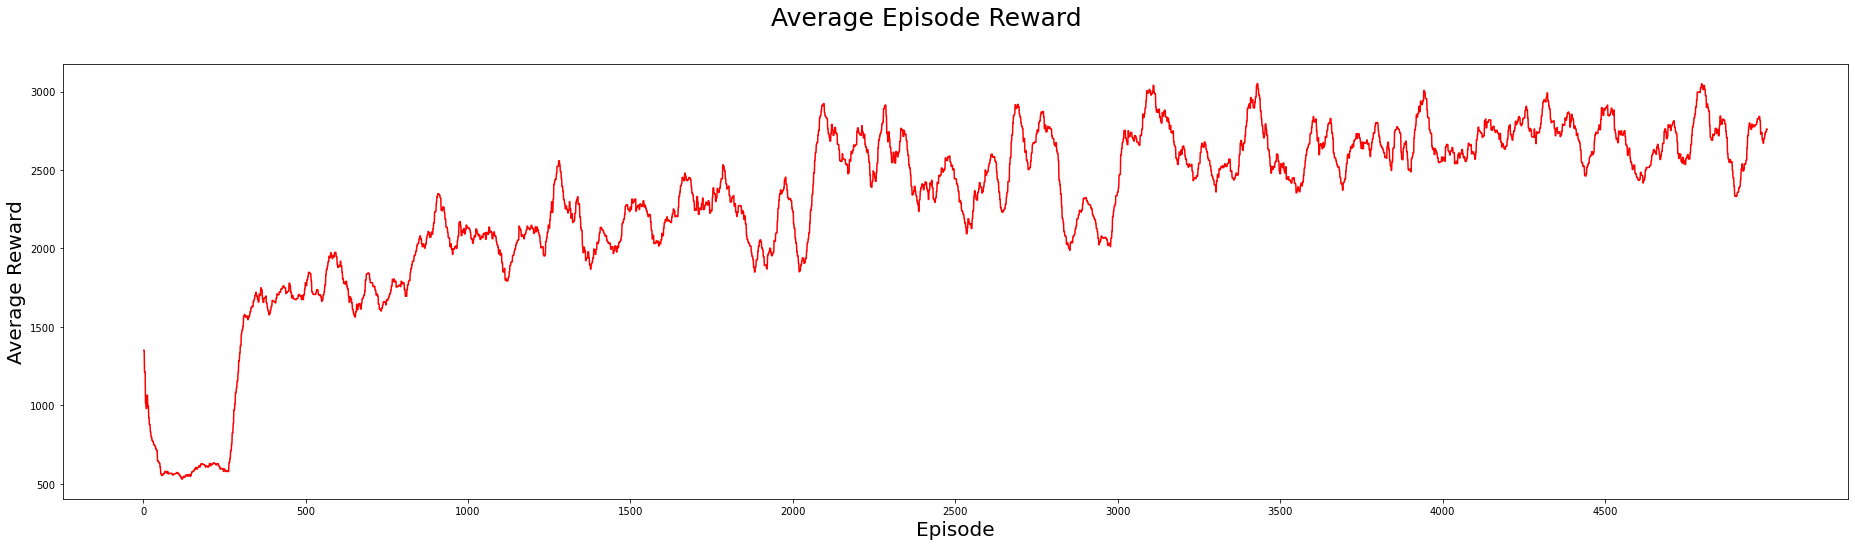

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
fig.suptitle('Average Episode Reward', fontsize=25)
                
ax.plot(range(NUM_ITERS), episode_reward_mean, "-r")

ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Average Reward', fontsize=20)
ax.set_xticks(np.arange(0, NUM_ITERS, 500))

fig.savefig('Band/Average Episode Reward_Band.png')

scipy.io.savemat('Band/episode_reward_mean.mat', mdict = {'episode_reward_mean': episode_reward_mean})

## 5. Generate and Visualize the Environment's Dense Logs

At any point during training, we would also want to inspect the environment's dense logs in order to deep-dive into the training results. Introduced in our [basic tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb#Visualize-using-dense-logging), dense logs are basically logs of each agent's states, actions and rewards at every point in time, along with a snapshot of the world state.

There is a way to fetch the environment's dense logs using the trainer object.

### 5a. Generate a dense log from the most recent trainer policy model weights

We may also use the trainer object directly to play out an episode. The advantage of this approach is that we can re-sample the policy model any number of times and generate several rollouts.

In [37]:
from modified_ai_economist.foundation.scenarios.utils import social_metrics


def generate_rollout_from_current_trainer_policy(trainer, env_obj, num_dense_logs=1):
    dense_logs = {}
    
    for idx in range(num_dense_logs):
        productivity = np.zeros(env_obj.env.episode_length)        
        equality = np.zeros(env_obj.env.episode_length)
        maximin = np.zeros(env_obj.env.episode_length)
        
        coin_endowments = np.zeros((env_obj.env.episode_length, env_obj.env.n_agents))
        wood_endowments = np.zeros((env_obj.env.episode_length, env_obj.env.n_agents))
        stone_endowments = np.zeros((env_obj.env.episode_length, env_obj.env.n_agents))
        iron_endowments = np.zeros((env_obj.env.episode_length, env_obj.env.n_agents))
        
        lump_sum_actual = np.zeros((env_obj.env.episode_length, env_obj.env.n_agents))
            
        wood_amount_world = np.zeros(env_obj.env.episode_length)
        stone_amount_world = np.zeros(env_obj.env.episode_length)
        iron_amount_world = np.zeros(env_obj.env.episode_length)
        
        # Set initial states      
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()        
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        
        for t in range(env_obj.env.episode_length):
            coin_endowments[t] = np.array([agent.total_endowment("Coin") for agent in env_obj.env.world.agents])
            wood_endowments[t] = np.array([agent.total_endowment("Wood") for agent in env_obj.env.world.agents])
            stone_endowments[t] = np.array([agent.total_endowment("Stone") for agent in env_obj.env.world.agents])
            iron_endowments[t] = np.array([agent.total_endowment("Iron") for agent in env_obj.env.world.agents])
            
            lump_sum_actual[t] = np.array([env_obj.env._components[3].lump_sum_actual[agent.idx] for agent in env_obj.env.world.agents])
        
            productivity[t] = social_metrics.get_productivity(coin_endowments[t])        
            equality[t] = social_metrics.get_equality(coin_endowments[t])
            maximin[t] = social_metrics.get_maximin(coin_endowments[t])
        
            for r in range(env_obj.env.world_size[0]):
                for c in range(env_obj.env.world_size[1]):
                    if len(env_obj.env.world.location_resources(r, c)) > 0:
                        try: 
                            if env_obj.env.world.location_resources(r, c)["Wood"]:
                                wood_amount_world[t] = wood_amount_world[t] + 1
                        except Exception:
                            pass
                        try: 
                            if env_obj.env.world.location_resources(r, c)["Stone"]:
                                stone_amount_world[t] = stone_amount_world[t] + 1
                        except Exception:
                            pass
                        try: 
                            if env_obj.env.world.location_resources(r, c)["Iron"]:
                                iron_amount_world[t] = iron_amount_world[t] + 1
                        except Exception:
                            pass
   
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):                
                
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )[0]

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )[0]

            obs, rew, done, info = env_obj.step(actions)        
            
            if done['__all__']:
                break
        
        dense_logs[idx] = env_obj.env.dense_log
          
    return dense_logs, productivity, equality, maximin, coin_endowments, wood_endowments, stone_endowments, iron_endowments, lump_sum_actual, wood_amount_world, stone_amount_world, iron_amount_world

In [38]:
dense_logs, productivity, equality, maximin, coin_endowments, wood_endowments, stone_endowments, iron_endowments, lump_sum_actual, wood_amount_world, stone_amount_world, iron_amount_world = generate_rollout_from_current_trainer_policy(trainer, env_obj, num_dense_logs=1)

### 5b. Visualizing the episode dense logs

Once we obtain the dense logs, we can use the plotting utilities we have created to examine the episode dense logs and visualize the the world state, agent-wise quantities, movement, and trading events.

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 _____|_ Agent  4 ____
Cost (Wood)    :   2.65 (n= 82) |   2.84 (n= 63) |   2.97 (n=159) |   2.89 (n=141) |   2.87 (n=120)
Cost (Stone)   :   3.00 (n= 51) |   2.87 (n=100) |   2.94 (n=134) |   2.91 (n= 69) |   2.73 (n= 90)
Cost (Iron)    :   3.26 (n=111) |   3.62 (n=200) |   4.03 (n= 88) |   3.75 (n=173) |   3.61 (n=142)

Income (Wood)  :   2.74 (n=117) |   3.00 (n=135) |   3.00 (n= 96) |   2.84 (n=110) |   2.77 (n=107)
Income (Stone) :   2.70 (n=132) |   3.12 (n= 72) |   2.71 (n= 59) |   3.05 (n= 88) |   2.92 (n= 93)
Income (Iron)  :   3.55 (n=140) |   3.79 (n=132) |   3.98 (n=168) |   3.80 (n=127) |   3.10 (n=147)
Income (Build) :  20.26 (n= 36) |  37.84 (n=144) |  47.37 (n=134) |  37.56 (n=155) |  17.32 (n= 94)


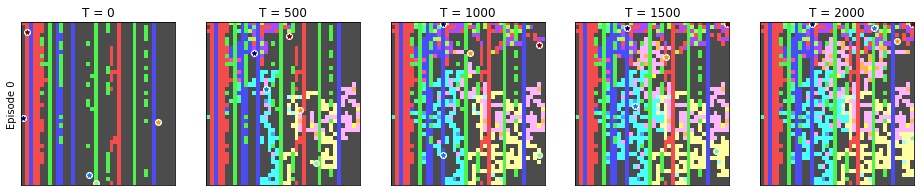

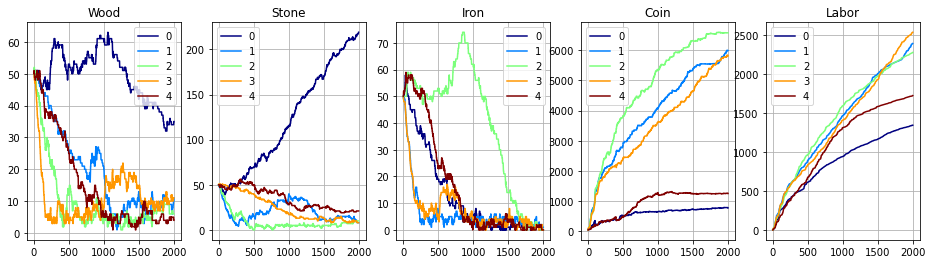

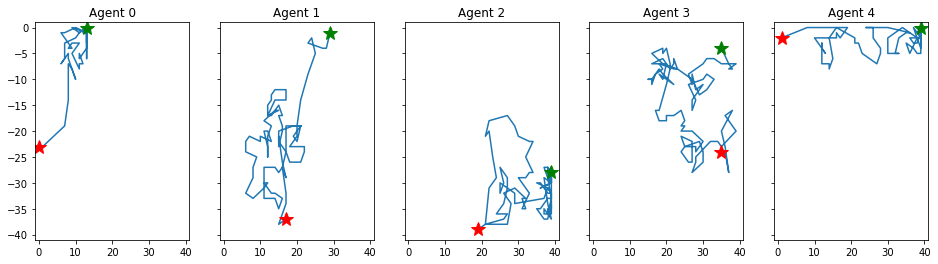

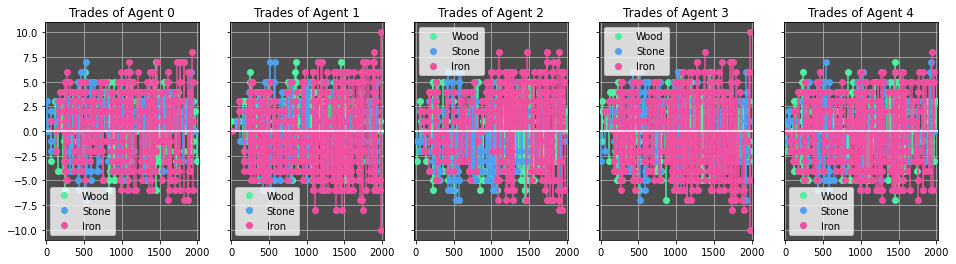

In [39]:
(fig0, fig1, fig2, fig3), incomes, endows, c_trades, all_builds, variables_matrix = plotting2.breakdown(dense_logs[0], environment_type = "Band", episode_length=2000)

In [40]:
incomes

{'Sell Wood': [320, 405, 288, 312, 296],
 'Buy Wood': [-217, -179, -473, -408, -344],
 'Sell Stone': [356, 225, 160, 268, 272],
 'Buy Stone': [-153, -287, -394, -201, -246],
 'Sell Iron': [497, 500, 668, 483, 455],
 'Buy Iron': [-362, -725, -355, -648, -513],
 'Build': [729.5277977073268,
  5448.700595471586,
  6347.493688318413,
  5822.450447814552,
  1628.278386039889],
 'Total': array([1170.52779771, 5387.70059547, 6241.49368832, 5628.45044781,
        1548.27838604])}

In [41]:
endows

[778, 5992, 6576, 5814, 1254]

In [42]:
c_trades

{'Wood': [{'t': 2,
   't_ask': 1,
   't_bid': 2,
   'commodity': 'Wood',
   'buyer': 4,
   'bid': 5,
   'bid_lifetime': 0,
   'seller': 1,
   'ask': 1,
   'ask_lifetime': 1,
   'price': 1,
   'cost': 1,
   'income': 1},
  {'t': 3,
   't_ask': 3,
   't_bid': 3,
   'commodity': 'Wood',
   'buyer': 0,
   'bid': 0,
   'bid_lifetime': 0,
   'seller': 4,
   'ask': 0,
   'ask_lifetime': 0,
   'price': 0,
   'cost': 0,
   'income': 0},
  {'t': 13,
   't_ask': 11,
   't_bid': 13,
   'commodity': 'Wood',
   'buyer': 2,
   'bid': 3,
   'bid_lifetime': 0,
   'seller': 3,
   'ask': 3,
   'ask_lifetime': 2,
   'price': 3,
   'cost': 3,
   'income': 3},
  {'t': 17,
   't_ask': 17,
   't_bid': 5,
   'commodity': 'Wood',
   'buyer': 3,
   'bid': 1,
   'bid_lifetime': 12,
   'seller': 4,
   'ask': 1,
   'ask_lifetime': 0,
   'price': 1,
   'cost': 1,
   'income': 1},
  {'t': 22,
   't_ask': 16,
   't_bid': 22,
   'commodity': 'Wood',
   'buyer': 4,
   'bid': 3,
   'bid_lifetime': 0,
   'seller': 3,
   '

In [43]:
all_builds

[{'t': 0,
  'builder': 3,
  'type': 'blue',
  'loc': [24, 35],
  'income': 40.21116959077061},
 {'t': 0,
  'builder': 1,
  'type': 'green',
  'loc': [37, 17],
  'income': 42.64074027894495},
 {'t': 4,
  'builder': 3,
  'type': 'blue',
  'loc': [24, 36],
  'income': 40.21116959077061},
 {'t': 4,
  'builder': 0,
  'type': 'green',
  'loc': [23, 0],
  'income': 13.606019205501108},
 {'t': 6, 'builder': 2, 'type': 'red', 'loc': [39, 20], 'income': 50.0},
 {'t': 9,
  'builder': 1,
  'type': 'green',
  'loc': [37, 16],
  'income': 42.64074027894495},
 {'t': 11, 'builder': 2, 'type': 'red', 'loc': [39, 21], 'income': 50.0},
 {'t': 11,
  'builder': 4,
  'type': 'red',
  'loc': [2, 0],
  'income': 25.078965635376555},
 {'t': 21, 'builder': 2, 'type': 'red', 'loc': [38, 21], 'income': 50.0},
 {'t': 22,
  'builder': 3,
  'type': 'blue',
  'loc': [25, 36],
  'income': 40.21116959077061},
 {'t': 22,
  'builder': 1,
  'type': 'green',
  'loc': [37, 18],
  'income': 42.64074027894495},
 {'t': 24, 'bu

In [44]:
variables_matrix

array([[[        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan, 42.64074028],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
         40.21116959,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan]],

       [[        nan,  3. 

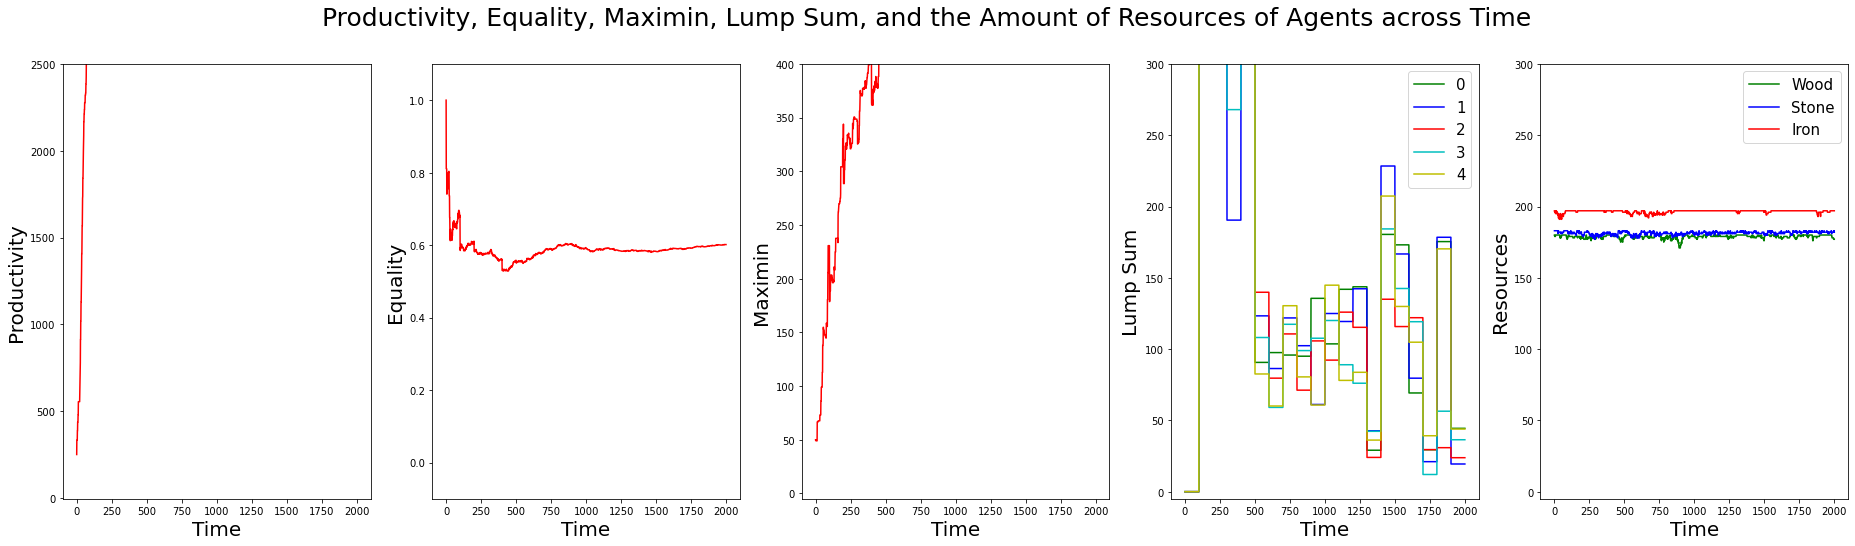

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(32, 8), squeeze=False)
fig.suptitle('Productivity, Equality, Maximin, Lump Sum, and the Amount of Resources of Agents across Time', fontsize=25)

ax = axes[0, 0]
ax.plot(range(0, env_obj.env.episode_length), productivity, "-r")
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Productivity', fontsize=20)
ax.set_ylim((-5, 2500))

ax = axes[0, 1]
ax.plot(range(0, env_obj.env.episode_length), equality, "-r")
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Equality', fontsize=20)
ax.set_ylim((-0.1, 1.1))

ax = axes[0, 2]
ax.plot(range(0, env_obj.env.episode_length), maximin, "-r")
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Maximin', fontsize=20)
ax.set_ylim((-5, 400))

ax = axes[0, 3]
ax.plot(range(0, env_obj.env.episode_length), lump_sum_actual.T[0], "-g", label='0')
ax.plot(range(0, env_obj.env.episode_length), lump_sum_actual.T[1], "-b", label='1')
ax.plot(range(0, env_obj.env.episode_length), lump_sum_actual.T[2], "-r", label='2')
ax.plot(range(0, env_obj.env.episode_length), lump_sum_actual.T[3], "-c", label='3')
ax.plot(range(0, env_obj.env.episode_length), lump_sum_actual.T[4], "-y", label='4')
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Lump Sum', fontsize=20)
ax.set_ylim((-5, 300))
ax.legend(fontsize=15)

ax = axes[0, 4]
ax.plot(range(0, env_obj.env.episode_length), wood_amount_world, "-g", label='Wood')
ax.plot(range(0, env_obj.env.episode_length), stone_amount_world, "-b", label='Stone')
ax.plot(range(0, env_obj.env.episode_length), iron_amount_world, "-r", label='Iron')
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Resources', fontsize=20)
ax.set_ylim((-5, 300))
ax.legend(fontsize=15)

fig.savefig('Band/Productivity, Equality, Maximin, Lump Sum, and the Amount of Resources of Agents across Time_Band.png')

scipy.io.savemat('Band/productivity.mat', mdict = {'productivity': productivity})
scipy.io.savemat('Band/equality.mat', mdict = {'equality': equality})
scipy.io.savemat('Band/maximin.mat', mdict = {'maximin': maximin})

scipy.io.savemat('Band/lump_sum_actual.mat', mdict = {'lump_sum_actual': lump_sum_actual})

scipy.io.savemat('Band/wood_amount_world.mat', mdict = {'wood_amount_world': wood_amount_world})
scipy.io.savemat('Band/stone_amount_world.mat', mdict = {'stone_amount_world': stone_amount_world})
scipy.io.savemat('Band/iron_amount_world.mat', mdict = {'iron_amount_world': iron_amount_world})

In [46]:
# Shutdown Ray after use
ray.shutdown()

And that's it for now. See you in the next tutorial :)